In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dolfin import *

plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [2]:
def transient_adv_diff_2d_R11(mesh_2d, mu, init_cond, dt_num, steps, method):
    # Input
    # nx:     number of elements
    
    # Output
    # u:      the solution, dolfin function

    V = FunctionSpace(mesh_2d, 'CG', 1)
    Vec = VectorFunctionSpace(mesh_2d, 'CG', 1)
    DG_space = FunctionSpace(mesh_2d, 'DG', 0)
    
    u = TrialFunction(V)
    w = TestFunction(V)
    u0 = project(init_cond, V)
    adv = project(Expression( ('-x[1]+0.5', 'x[0]-0.5'), degree=1 ), Vec )
    
    u_list = [u0.copy()]
    
    class AllBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary
        
    sub_domains = MeshFunction("size_t", mesh_2d, mesh_2d.topology().dim() - 1)
    sub_domains.set_all(0)
    
    AllBoundary().mark(sub_domains, 2)
    bc_out = DirichletBC(V, Constant(0.0), sub_domains, 2)

    bcs = [bc_out]
    
    dt = Constant(dt_num)
    one = Constant(1.0)
    
    def L(w, u):
        return w*dot(adv, grad(u)) + Constant(mu)*inner(grad(w), grad(u))
        
    delta_u = u - u0
    W = Constant(0.5)
    
    t0 = 0.0
    s_expr_0 = Expression('( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2) ) <= 0.04 ? exp(-pow(t, 10) )*cos(2.5*pi*pow( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2), 0.5 ) ) : 0.0', degree=1, t=t0)
    s_expr_1 = Expression('( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2) ) <= 0.04 ? exp(-pow(t, 10) )*cos(2.5*pi*pow( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2), 0.5 ) ) : 0.0', degree=1, t=t0+dt_num)

    s0 = project(s_expr_0, V)
    s1 = project(s_expr_1, V)
    
    ww = (w*s0-L(w, u0)) + W*(s1-s0)
    
    # The residual term used for stabilization
    def R(u, u0):
        return delta_u/dt + W*(dot(adv, grad(u-u0)) ) \
               - (s0 - dot(adv, grad(u0))) - W*(s1-s0)
    
    h = 1.0/40 # nx = 40. Hard coded value
    #h = mesh_2d.hmin()
    
    # the stabilization constant. p. 232, Soulaimani and Fortin (1994), Codina (2000)
    tau = 1.0/(2.0/dt_num + 2.0*(adv[0]**2 + adv[1]**2)**0.5/h + 4.0*mu/h**2)
    
    #tau = ( (2.0/dt_num)**2 + (2.0*(dot(adv, adv)**0.5)/h)**2 + 9.0*(4.0*mu/h**2)**2 )**(-0.5)
    #tau = project(tau, DG_space)
    #tau = 0.5*(tau_x*abs(adv[0])*h + tau_y*abs(adv[1])*h)/ (dot(adv, adv)**0.5)
    
    if method=='Galerkin':
        F = (w*delta_u/dt + W*L(w, u - u0) - ww)*dx
    
    elif method=='SUPG':
        def P(w):
            #return W*dot(adv, as_matrix([[tau_x, 0.0], [0.0, tau_y]])*grad(w))
            return tau*W*dot(adv, grad(w))
        
        F = (w*delta_u/dt + W*L(w, u - u0) - ww)*dx\
            + P(w)* R(u, u0) *dx
    
    a, L = lhs(F), rhs(F)
    
    A = assemble(a)
    u = Function(V)
    
    for i in range(steps):
        b = assemble(L)
        
        [bc.apply(A, b) for bc in bcs]
        
        solve(A, u.vector(), b)
        u0.assign(u)
        u_list.append(u0.copy())
        
        t0 = t0 + dt_num
        s_expr_0 = Expression('( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2) ) <= 0.04 ? exp(-pow(t, 10) )*cos(2.5*pi*pow( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2), 0.5 ) ) : 0.0', degree=1, t=t0)
        s_expr_1 = Expression('( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2) ) <= 0.04 ? exp(-pow(t, 10) )*cos(2.5*pi*pow( pow(x[0]-0.2, 2) + pow(x[1]-0.2, 2), 0.5 ) ) : 0.0', degree=1, t=t0+dt_num)
        
        s0.assign(project(s_expr_0, V))
        s1.assign(project(s_expr_1, V))
        
    return u_list, V.tabulate_dof_coordinates().T

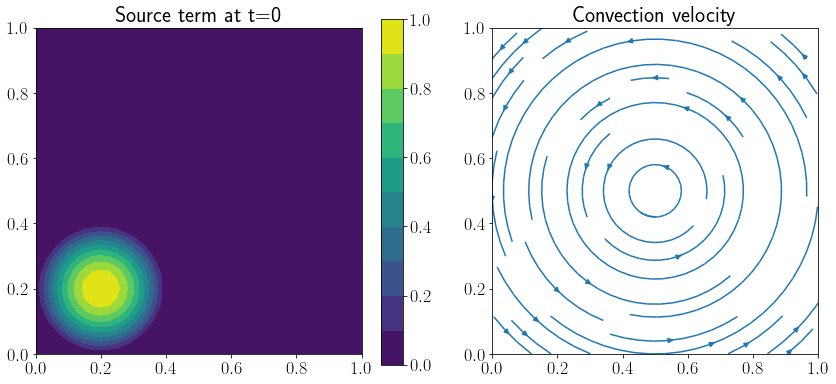

In [3]:
# Definition of the transient rotating pulse problem, mu=1e-5. u=0 on all boundaries.
# Fig. 5.19, Source term and convection velocity

x_space = np.linspace(0, 1, 41)

xx, yy = np.meshgrid(x_space, x_space)
t = 0.0

source = np.zeros_like(xx)
ind = (xx-0.2)**2 + (yy-0.2)**2 <= 0.04
source[ind] = np.exp(-t**10)*np.cos(0.5*np.pi*5*((xx[ind]-0.2)**2 + (yy[ind]-0.2)**2)**0.5)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
cb = ax[0].contourf(xx, yy, source, levels=np.linspace(0,1,11))
ax[0].set_title('Source term at t=0')
ax[0].set_aspect('equal', 'box')

cbaxes = fig.add_axes([0.47, 0.1, 0.02, 0.8]) 
fig.colorbar(cb, cax=cbaxes)

ax[1].streamplot(xx, yy, -(yy-0.5), xx-0.5, density=0.6)
ax[1].set_aspect('equal', 'box')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_title('Convection velocity')
plt.show()

In [4]:
nx = 40
ny = 40
mesh_2d = RectangleMesh.create([Point(0,0), Point(1,1)], [nx, ny], CellType.Type.quadrilateral)
#mesh_2d = RectangleMesh(Point(0,0), Point(1,1), nx, ny)
#coord_x = mesh_2d.coordinates()[:,0]
#coord_y = mesh_2d.coordinates()[:,1]

h = 1.0/nx
adv = 1.0
dt_num = 1.0/nx

CFL = adv*dt_num/h
end_time = 5.0*np.pi #0.05
#end_time = 0.05

print(int(end_time/dt_num))

print('Courant number = ', CFL)

628
Courant number =  1.0


In [5]:
u, coord = transient_adv_diff_2d_R11(mesh_2d, mu=1e-5 \
                              , init_cond=Expression('0.0', degree=1)\
                              , dt_num=dt_num, steps=int(end_time/dt_num), method='Galerkin')

coord_x = coord[0]
coord_y = coord[1]

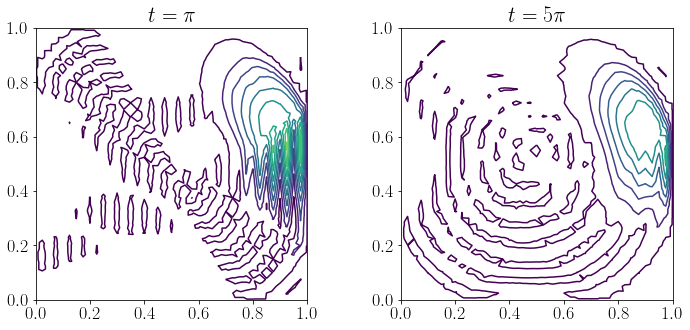

In [6]:
# Fig. 5.20 Galerkin with Crank-Nicolson, C=1

fig, ax = plt.subplots(1, 2, figsize=(12,5))

cb = ax[0].tricontour(coord_x, coord_y, u[126].vector()[:], levels=np.linspace(6e-3, 1.0, 11))
cb = ax[1].tricontour(coord_x, coord_y, u[-1].vector()[:], levels=np.linspace(6e-3, 1.0, 11))

ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')

ax[0].set_title('$t= \pi$')
ax[1].set_title('$t=5 \pi$')
#fig.colorbar(cb)
plt.show()

In [7]:
end_time = 5.0*np.pi

u, coord = transient_adv_diff_2d_R11(mesh_2d, mu=1e-5 \
                              , init_cond=Expression('0.0', degree=1)\
                              , dt_num=dt_num, steps=int(end_time/dt_num), method='SUPG')

coord_x = coord[0]
coord_y = coord[1]

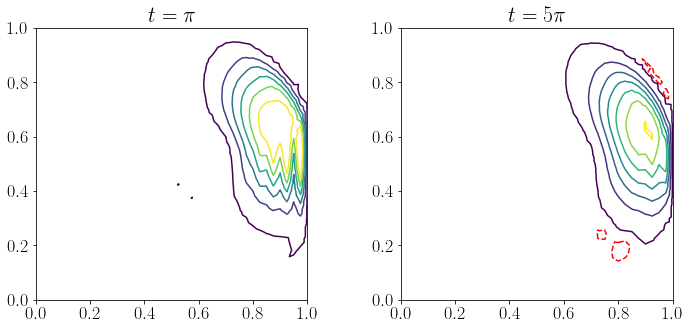

In [8]:
# Fig. 5.21 SUPG with Crank-Nicolson, C=1.
# The negative contours are plotted in red.

fig, ax = plt.subplots(1, 2, figsize=(12,5))

cb = ax[0].tricontour(coord_x, coord_y, u[126].vector()[:], levels=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5])
cb = ax[1].tricontour(coord_x, coord_y, u[-1].vector()[:], levels=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

ax[1].tricontour(coord_x, coord_y, u[-1].vector()[:], levels=[-0.005], colors='r')

ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')

ax[0].set_title('$t= \pi$')
ax[1].set_title('$t=5 \pi$')
#fig.colorbar(cb)
plt.show()